# Predicting Property Prices From Zillow Data

## Key Takeaways

- Major factors determining property price are:
    - square feet
    - number of bathrooms
    - location
- A Lasso Lars regression model predicts better than baseline, but is less predictive of luxury houses.
- Getting more data on the geographic location of the house will be more helpful in determining the price.


## Contents <a name='contents'></a>

*Note: the following links will only work on local copies of this notebook.*

1. <a href='#introduction'>Introduction</a>
2. <a href='#wrangle'>Wrangle Data</a>
    1. <a href='#acquire'>Acquire the Data</a>
    2. <a href='#prepare'>Prepare and Clean the Data</a>
3. <a href='#explore'>Explore Data</a>
    1. <a href='#hypothesis1'>Are `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` related?</a>
    2. <a href='#hypothesis2'>What is the connection between `bedroomcnt`, `bathroomcnt` and `taxvaluedollarcnt`?</a>
    3. <a href='#hypothesis3'>What is the relationship between `county` and `taxvaluedollarcnt`?</a>
    4. <a href='#hypothesis4'>What is the relationship between `latitude` \ `logitude` \ `county` and `taxvaluedollarcnt`? </a>
    5. <a href='#explorediscussion'>Explore discussion </a>
4. <a href='#models'>Models</a>
    1. <a href='#baseline'>Baseline Models </a>
    2. <a href='#linearregression'>Linear Regression Model </a>
    3. <a href='#polynomial'>Polynomial Regression Model</a>
    4. <a href='#tweedie'>Tweedie Regressor </a>
    5. <a href='#evaluatingmodels'>Evaluating The Models Discussion </a>
    6. <a href='#test'>Using the model on Test data </a>
5. <a href='#conclusion'>Conclusion </a>
    
The following modules are used in this notebook:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

import wrangle
import explore

## Introduction <a name='introduction'></a>

Zillow data was pulled from the database, and analyzed to determine which features can best determine the property value of a house.  This project is divided into three parts: wrangle, explore, and model.  Wrangle explains how the data is acquired and prepared for analysis and processing.  Explore looks at the data and applies visualization and hypothesis testing to discover drivers of the property value.  Finally, model builds a linear regression model to predict property values from the data. Each section and select subsections include a short list of key takeaways; these are followed by a discussion detailing the analysis choices made that are relevant to that (sub)section.

### Goals
- Test at least four drivers of the property value, so that the data and the model predictions can be better understood
- Wrangle data to prepare it for analysis, so that the data pulled in the future can be wrangled in a similar manner
- Build a model that beat the baseline models, so that Zillow can display information to the users of its website
- Include a report for future reference so that this project can be built upon in the future

### Project Plan
- Explore at least four variables of property prices
- Visualize variables
- Hypothesis test at least two variables
- Write this final report
- Python scripts that allow for the project to be reproducible

<a href='#contents'>Back to contents</a>

## Wrangle Data <a name='wrangle'></a>

#### Key Wrangle  Takeaways

- $\approx0.98$ of the data is retained or the original 52,441 rows
- 10 of the 59 rows are retained
- Data is acquired from the SQL database
- Any column with $> 0.01$ of nulls is dropped
- Redundant and innaccurate columns with significant missing data are removed
- Extreme outliers are removed from the data; this was determined based off of the typical customer of Zillow.
- Any remaining null valued rows are dropped

<a href='#contents'>Back to contents</a>

### Acquire the data <a name='acquire'></a>

#### Key Acquire Takeaways

- `wrangle.get_zillow_data()` is used to get the data from the database.
- 58 columns and 52441 rows are imported from the data

#### Discussion

Below the data is acquired via the `wrangle.get_zillow_data()` function. This function will query the SQL database, unless there is a saved .csv file present in the current directory.  The name of the file is set by the `wrangle.FILENAME` constant. This function has the following parameters:
- `query_db = False` (bool) : forces a query to the SQL database even if the .csv file is present.

In [2]:
df = wrangle.get_zillow_data() #acquire database via the database or saved .csv file
df.sample(3) #display three lines of the data

Returning saved csv file.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
1850,241668,11187721,1.0,NaN,NaN,2.0,4.0,NaN,6.0,2.0,...,NaN,NaN,185993.0,232491.0,2016.0,46498.0,3513.73,Y,15.0,6.037910e+13
31400,2955960,11286785,1.0,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,NaN,NaN,82353.0,144505.0,2016.0,62152.0,2491.17,NaN,NaN,6.037901e+13
18347,493908,10844352,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,NaN,NaN,93156.0,483906.0,2016.0,390750.0,5905.67,NaN,NaN,6.037128e+13


Determine the shape of the dataframe.  This tuple will be used later to calculate the percent of data retained after cleaning.

In [3]:
original_shape = df.shape #get the shape attribute of the dataframe
original_shape # display the variable contents

(52441, 59)

In order to determine the extent of missing data, `wrangle.return_col_percent_null()` is used. The function has the followng parameters:
- `df` (DataFrame) : a dataframe containing the Zillow data

This function will return a dataframe with the following columns:
- `column_name` : The name of the column of the relevant column of `df`
- `percent_null` : The percent of rows in the `column_name` column of `df` that are null values
- `count_null` : The total number of null values in the `column_name` column of `df`

The output of the function is as follows.

In [4]:
null_proportion_df = wrangle.return_col_percent_null(df) #call the custom function
null_proportion_df.sample(15) #display the dataframe sample

,column_name,percent_null,count_null
46,yardbuildingsqft17,0.9631,50504
35,propertyzoningdesc,0.3546,18593
6,bedroomcnt,0.0000,0
47,yardbuildingsqft26,0.9988,52378
28,poolcnt,0.7884,41345
10,decktypeid,0.9926,52052
38,regionidcounty,0.0000,0
41,roomcnt,0.0000,0
0,id,0.0000,0
21,garagecarcnt,0.6565,34426


<a href='#contents'>Back to contents</a>

### Prepare and Clean the Data <a name='prepare'></a>

#### Key Prepare and Clean Takeaways
- $\approx0.98$ of the data is retained
- Columns with high percentage of nulls are dropped
- Redundant and innacurate data is also dropped
- Extreme outliers and remaining null valued rows are dropped
- `fips` values are converted to equivalent county names
- `latitude` and `longitude` are made into correct values

Consider the columns that have greater tha $0.01$ of the rows having null values. Because there is significant data missing, all of these columns will be dropped.  Note, however, that some of these columns do have the majority of their data.  These columns could be used in a future analysis, see the <a href='#conclusion'>conclusion</a> for more discussion. The `null_proportion_df` is used to display these columns.

In [5]:
null_proportion_df[null_proportion_df.percent_null > 0.01]

,column_name,percent_null,count_null
2,airconditioningtypeid,0.7399,38803
3,architecturalstyletypeid,0.9987,52371
4,basementsqft,0.9991,52394
7,buildingclasstypeid,1.0000,52441
8,buildingqualitytypeid,0.3566,18701
10,decktypeid,0.9926,52052
11,finishedfloor1squarefeet,0.9165,48060
14,finishedsquarefeet13,1.0000,52441
15,finishedsquarefeet15,1.0000,52441
16,finishedsquarefeet50,0.9165,48060


Some of the remaining columns contain significant outliers. These can be dropped Consider the following columns:
- `bathroomcnt` : Most houses for Zillow users will have at most 6 bathrooms; any rows with more than 6 bathrooms are dropped.  In addition, any row that reports no bathrooms is dropped
- `bedroomcnt` : Similar to the number of bathrooms, any rows with no bedrooms or more than 6 bedrooms is dropped.  A typical homebuyer will not have more than 6 bedrooms.
- `calculatedfinishedsquarefeet` : Houses with less than 150 square feet or more than 6000 square feet are excluded from the analysis. Most of the rows are much smaller than this, and a typical user will not be interested in this type of house.
- `lotsizesquarefeet` : Any lot that is over 5 acres is excluded.  Most houses are on lots a fifth of the size.

Note that this continues to leave a significant number of outliers in the dataset; however, these provide more "mainstream" customers.

The following boxplots show the extent of these outliers:

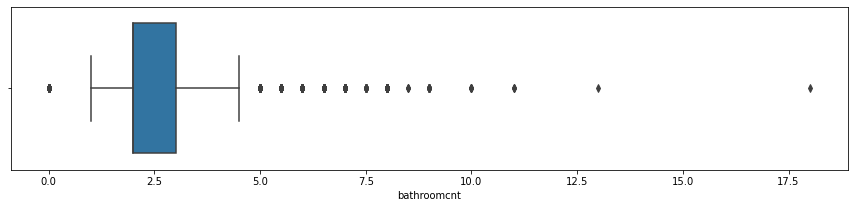

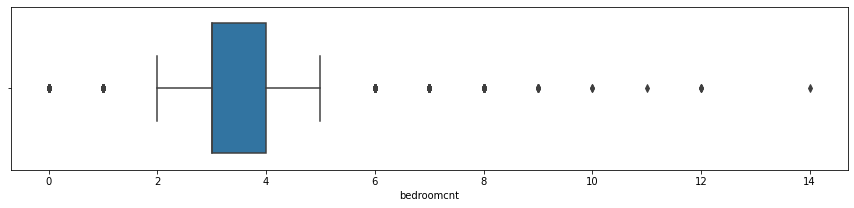

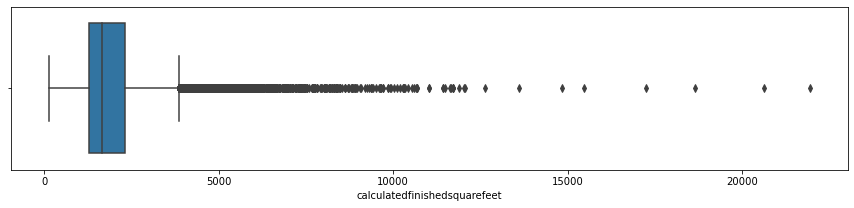

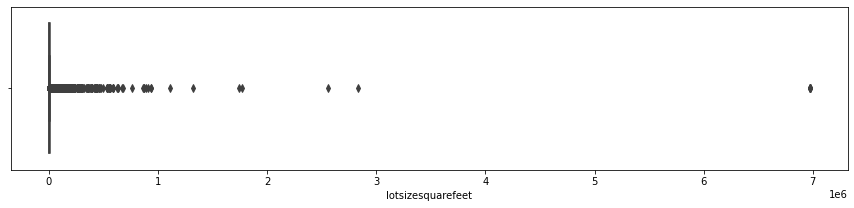

In [6]:
#columns to plot
columns_boxplot = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet']
for col in columns_boxplot:
    #size the figure
    plt.figure(figsize=(15,3))
    #make a boxplot
    sns.boxplot(x=col, data=df)
    #label the boxplot
    plt.xlabel(col)
    #display the boxplot
    plt.show()

The above information is also displayed in numeric form below.

In [7]:
df[columns_boxplot].describe() #describe the relevant columns

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet
count,52441.000000,52441.000000,52359.000000,5.207200e+04
mean,2.299403,3.300681,1922.890754,1.133962e+04
std,1.022772,0.949094,1004.365838,8.674763e+04
min,0.000000,0.000000,128.000000,2.360000e+02
25%,2.000000,3.000000,1268.000000,5.583000e+03
50%,2.000000,3.000000,1659.000000,6.840500e+03
75%,3.000000,4.000000,2306.000000,8.798250e+03
max,18.000000,14.000000,21929.000000,6.971010e+06


Redundant data can also be dropped.  Consider the following columns:
- `calculatedbathnbr` and `fullbathcnt`, the data can be calculated from the other two columns
- `finishedsquarefeet12` is a repetition of `calculatedfinishedsquarefeet`
- `assessmentyear` can calso be dropped as it is all the same value, 2016.
- `rmcnt` contains significant missing values are can be inferred from the seemingly more reliable `bedroomcnt` and `bathroomcnt`

As an illustration, consider the `rmcnt` column.  It should be at least the sum of `bathroomcnt` and `bedroomcnt`, but isn't always.  In $0.26$ of the rows the data is wrong, assuming the counts for `bathroomcnt` and `bedroomcnt` are accurate.  

In [8]:
#Get the percent of rows where roomcnt is more than the sum of bedroomcnt and bathroomcnt
(df['roomcnt'] >= (df['bathroomcnt']+df['bedroomcnt'])).mean()

0.2617608359871093

Some of the data is not accurate.  Consider the `regionidzip` column.  It contains values that are outside of the range of zip code values for California:

In [9]:
df[['regionidzip']].describe() # display the stats for the column

,regionidzip
count,52415.000000
mean,96635.846380
std,4605.107533
min,95982.000000
25%,96206.000000
50%,96412.000000
75%,96995.000000
max,399675.000000


Some of the data is also in the wrong form.  For example `latitude` and `longitude` need to be multiplied by $10^{-6}$ to get values that are in the range for southern California.  This is illustrated by the first few rows.

In [10]:
df[['latitude', 'longitude']].head(3)

,latitude,longitude
0,33879703.0,-118406604.0
1,33976669.0,-117834686.0
2,33990330.0,-118414200.0


The `fips` column can also be mapped to the relevant county names of Los Angeles, Ventura and Orange.

Some columns contain useful information, but that would be outside of the scope of this project, see <a href='#conclusion'>conclusion</a> for a discussion.  These columns are dropped:
- `censustractandblock` and `rawcensustractandblock` are dropped
- `propertycountylandusecode` might be useful, but determing its meaning is outside of the scope of this project

Foreign key rows are dropped.  These are:
- `propertylandusetypeid`
- `regionidcounty`
- `id` : `parcelid` is used to identify rows instead.

Data leakage columns are also dropped.  these are `taxamount` and `structuretaxvaluedollarcnt`.

The remaining rows that have nulls are dropped as they represent a small ($ < 0.01$ of the data in the rows).

`wrangle.wrangle_zillow()` is used to drop the columns, fix the values and drop the null valued rows. Is takes as a parameter `df`, a dataframe object. It uses the following functions:
- `wrangle.zillow_drop_columns()` : drops the columns using `wrangle.COLUMNS_TO_DROP` module constant (see <a href='#appendix'>appendix</a> for more information on the constants of the `wrangle.py` module.
- `wrangle.prepare_zillow_data()` : removes null valued rows, outliers and fixes the `latitude`, `longitude`, and `fips` columns.  In additon, it casts the datatypes to more efficient data types (typically some size of a `uint`)

In [11]:
df = wrangle.wrangle_zillow(df) #call the function that cleans and prepares the data
df.sample(3) #display some rows

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,county
34812,17272152,3.0,4,2465,34.200490,-118.918240,6018.0,1997,611472,Ventura
46046,12293939,1.0,2,800,33.926579,-118.191671,6215.0,1948,325000,Los Angeles
13881,17098047,3.0,4,2263,34.367803,-119.066107,3960.0,2013,530000,Ventura


In [12]:
wrangle.return_col_percent_null(df)

,column_name,percent_null,count_null
0,parcelid,0.0,0
1,bathroomcnt,0.0,0
2,bedroomcnt,0.0,0
3,calculatedfinishedsquarefeet,0.0,0
4,latitude,0.0,0
5,longitude,0.0,0
6,lotsizesquarefeet,0.0,0
7,yearbuilt,0.0,0
8,taxvaluedollarcnt,0.0,0
9,county,0.0,0


There are no more nulls in the resulting dataframe.

In [13]:
(df.shape[0])/original_shape[0]

0.9781468698156023

$\approx0.98$ of the data is retained.

<a href='#contents'>Back to contents</a>

## Explore <a name='explore'></a>

### Key Explore Takeaways
- Data is split into `train`, `validate` and `test`
- All hypothesis testing is done use $α = 0.05$ 
- `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` are highly positively correlated
- `bedroomcnt` and `bathroomcnt` are correlated with `taxvaluedollarcnt`, but `bathroomcnt` is particularly correlated.  It might be better to only pass `bathroomcnt` in the model. 
- Orange county has a higher average house, this is probably due to location effects
- Generally the top $0.25$ of house prices are near the coast (for example, Orange county), and in downtown Los Angeles.


This section uses the `explore.py` module which includes the following functions:
- `plot_variable_pairs()` plots all the pairs of variables possible and includes a regression line displayed in red.  It has the following parameters:
    - `df` (DataFrame) : a dataframe object
    - `columns_x` (list) : a list of column names to plot on the x-axis
    - `columns_y` (list) : a list of column names to plot on the y-axis
    - `sampling` (int) : the number of points from the data to plot
- `plot_categorical_and_continuous_vars()` plots a strip plot, a box plot and a bar plot.  It has the following parameters:
    - `df` (DataFrame) : a dataframe object
    - `columns_cat` (list) : a list of categorical columns to split `df` by
    - `columns_cont` (list) : a list of continuous columns to plot
    - `sampling` (int) : number of points to plot
- `r_values_vars()` performs a pearson r correlation test on all the possible pairs of columns that are passed. It returns a dataframe containing the column names, the r-value, the p-value and a boolean representing if the null hypothesis can be rejected. It has the following parameters:
    - `df` (DataFrame) : a Dataframe object
    - `columns` (list) : the columns to hypothesis test
- `t_test_by_cat()` performs a t-test to determine if the mean of a subsample is different from the non-category sample.  It has the following parameters:
    - `df` (DataFrame) : a DataFrame object
    - `columns_cat` (list) : a list of categorical columns to split `df` by
    - `columns_cont` (list) : a list of continuous columns to test the mean

Before the exploration stange it is important to split the data into train, validate and test subsets.  This is done using the `wrangle.split_zillow_data()` function.  This function takes as its parameter `df` a dataframe object and returns three DataFrames: `train`, `validate` and `test`; these three dataframes are of descending size.

In [14]:
train, validate, test = wrangle.split_zillow_data(df) #split the data and store the returns in variables
train.shape[0], validate.shape[0], test.shape[0] #display the number of rows in each dataframe

(28725, 12311, 10259)

In addition consider the distribution of the target variable needs to be considered:

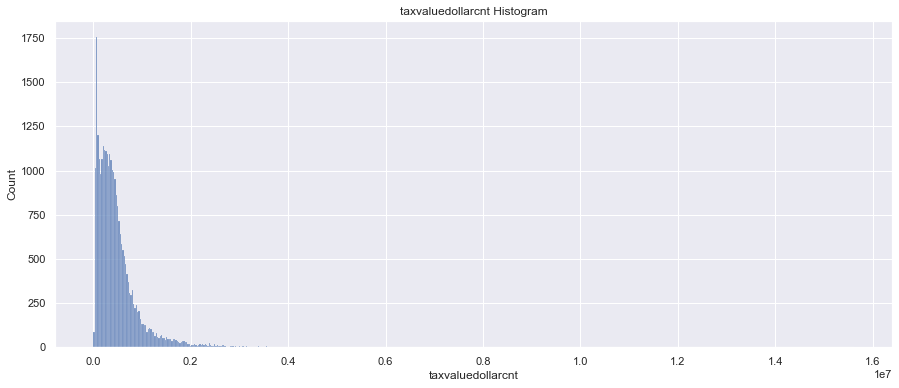

In [68]:
plt.figure(figsize=(15, 6))
sns.histplot(data=train, x='taxvaluedollarcnt')
plt.title('taxvaluedollarcnt Histogram')
plt.show()

There is a clear positive skew to the data. Moreover, there are some very extreme outliers.

<a href='#contents'>Back to contents</a>

### Are `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` related? <a name='hypothesis1'></a>

#### Key Takeaways
- `calculatedfinishedsquarefeet` has a high correlation with the target variable

Generally, bigger homes cost more than smaller homes.  Consider the following graph that includes the regression line in red.

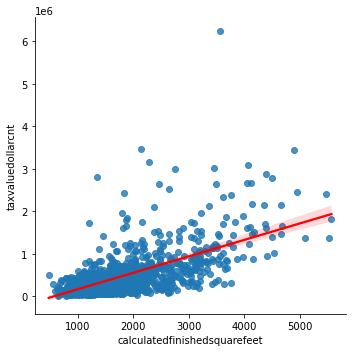

In [16]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['calculatedfinishedsquarefeet'])

There appears to be a strong positive correlation.  Consider the following null and alternative hypothesis:

$H_0$ : `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` are not correlated

$H_a$ : `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` are correlated

This can be tested using the `explore.r_values_vars()` function.

In [17]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x calculatedfinishedsquarefeet,0.552838,0.0,True


The p-value is low likely due to the size of the dataframe.  $H_0$ is likely false, and $H_a$ is likely true.

<a href='#contents'>Back to contents</a>

### What is the connection between `bedroomcnt`, `bathroomcnt` and `taxvaluedollarcnt`? <a name='hypothesis2'></a>

#### Key Takeaways
- `bathroomcnt` has a strong correlation with the target variable
- Number of bedrooms, the ratio between bedroom and bathrooms, and the sum of bedrooms and bathrooms were correlated, but less so.  They are probably largely colinear with `calculatedfinishedsquarefeet`, and it might be good to train a model without these categories

The number of bedroom and the number of bathrooms a house has correlated with the size of the house.  However, it might be the case that more expensive houses have more bathrooms, and likely more bedrooms.  In addition, it might be the case that more expensive houses have a lower ratio between bedrooms to bathroom -- that is, an expenisve house is more likely to have an ensuite bathroom for more bedrooms.

First, consider the correlation between `bedroomcnt` and `taxvaluedollarcnt`.  Consider the following graph:

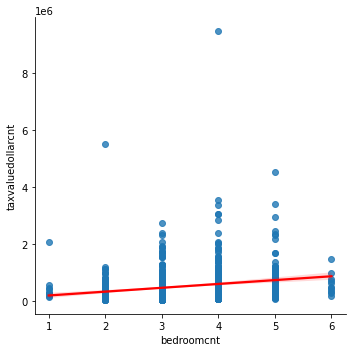

In [18]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['bedroomcnt'])

Consider the following hypothesis:

$H_0$ : `bedroomcnt` and `taxvaluedollarcnt` are unrelated

$H_a$ : `bedroomcnt` and `taxvaluedollarcnt` are related

Run a hypothesis test:

In [19]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'bedroomcnt'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x bedroomcnt,0.240511,0.0,True


$H_0$ is likely false.  However, the r-value is not particularly high.

Now consider the correlation between `bathroomcnt` and `taxvaluedollarcnt`.  Consider the following graph:

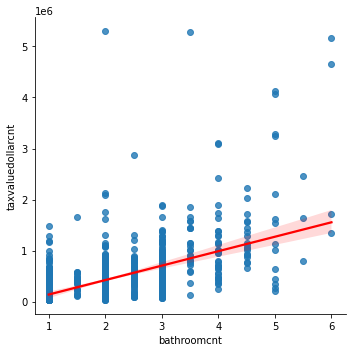

In [20]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['bathroomcnt'])

Consider the following hypothesis:

$H_0$ : `bathroomcnt` and `taxvaluedollarcnt` are unrelated

$H_a$ : `bathroomcnt` and `taxvaluedollarcnt` are related

Run a hypothesis test:

In [21]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'bathroomcnt'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x bathroomcnt,0.493155,0.0,True


$H_0$ is likely false.  The r-value is much higher than the correlation with `bedroomcnt`.  

Consider the ratio between `bedroomcnt` and `bathroomcnt` defined as $\text{ratio} = \frac{\text{`bathroomcnt`}}{\text{`bedroomcnt`}}$.  If the ratio is low then `taxvaluedollarcnt` is most likely higher.

Make a column first:

In [22]:
train['bed_bath_ratio'] = train['bedroomcnt']/train['bathroomcnt']

Graph the column

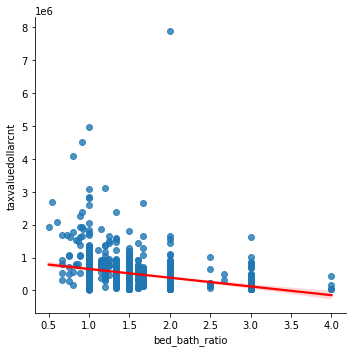

In [23]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['bed_bath_ratio'])

It looks like thhere is a correlation.  Consider the following hypothesis:

$H_0$ : There is no correlation between the bedroom-bathroom ratio and `taxvaluedollarcnt`

$H_a$ : There is a correlation between the bedroom-bathroom ratio and `taxvaluedollarcnt`

Run the hypothesis test:

In [24]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'bed_bath_ratio'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x bed_bath_ratio,-0.294967,0.0,True


$H_0$ is likely false. In addition the correlation is negative, as expected.  However, the correlation is not very high. 

It is worth considering a `min_rooms` defined as $\text{`bedroomcnt`} + \text{`bathroomcnt`}$.  Note that this is similar to the dropped `roomcnt` but will not have null values.  The houses will have at least `min_rooms`; this means that `bedroomcnt` and `bathroomcnt` can be dropped.

First make the column:

In [25]:
train['min_rooms'] = train['bedroomcnt'] + train['bathroomcnt']

Graph the column:

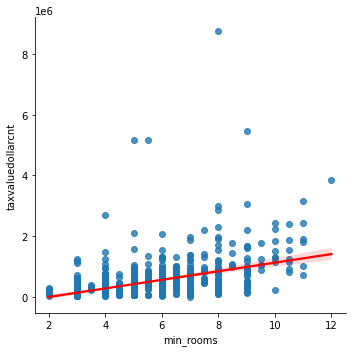

In [26]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['min_rooms'])

It looks like thhere is a correlation.  Consider the following hypothesis:

$H_0$ : There is no correlation between `min_rooms` and `taxvaluedollarcnt`

$H_a$ : There is a correlation between `min_rooms` and `taxvaluedollarcnt`

Run the hypothesis test:

In [27]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'min_rooms'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x min_rooms,0.409705,0.0,True


$H_0$ is likely false.  But the correlation is not very strong.  However, there is probably colinearity at work; therefore, `bedroomcnt` and `calculatedfinishedsquarefeet` might be columns to not train a model on.  Alternatively, keep `bathroomcnt` and consider the number of square feet to the number of bathrooms.

<a href='#contents'>Back to contents</a>

### What is the relationship between `county` and `taxvaluedollarcnt`? <a name='hypothesis3'></a>

#### Key Takeaways
- Orange county has the most expensive houses
- This is despite Orange county having the smallest lot sizes overall
- Most likely this is a function of location

Home pricers are often related to location; certain areas, because of nearby services such as schools, are more expensive than others.  Since there is county information in the dataset, the difference in which county has higher home prices and why is an important to explore.

First, consider the distribution of `taxvaluedollarcnt` by county.

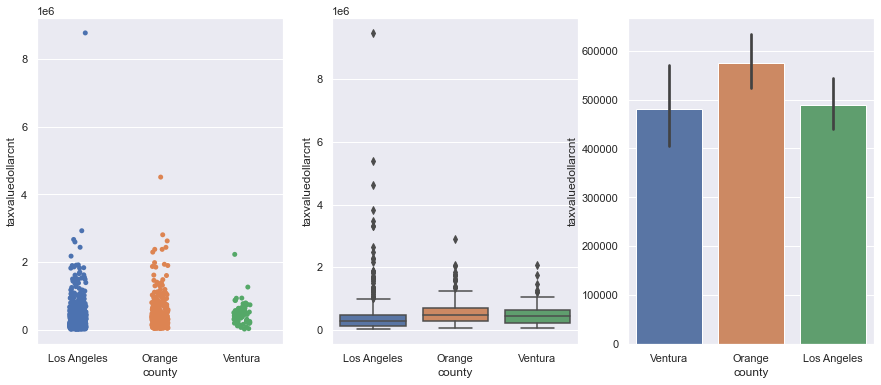

In [28]:
explore.plot_categorical_and_continuous_vars(train, columns_cat=['county'], columns_cont= ['taxvaluedollarcnt'])

Los Angeles county has a wider range of values than the other counties.  However, this is because of the high number of outliers, as can be seen in the strip plot and the boxplot of `taxvaluedollarcnt`.  This makes sense, the area is centered on the city of Los Angeles, which is the economic center of the region.  Of note is that Orange County's home prices on the whole look like they are higher than the other counties.  Consider the following numeric data.

In [29]:
train.groupby('county')['taxvaluedollarcnt'].describe().iloc[:,3:]

,min,25%,50%,75%,max
county,,,,,
Los Angeles,1000.0,163556.0,319263.0,543907.0,15618488.0
Orange,17949.0,277331.0,472160.0,716766.0,9323011.0
Ventura,9242.0,280006.0,440989.5,619006.5,3546703.0


This confirms what is shown on the box plot; not only is the minimum price in Orange county significantly higher than the other two counties--moreover, considering the $0.75$ percentile is $\approx \$11\text{k}$, there are a significant number of houses in Orange county that would be considered outliers in the other counties.  A caveat is that there are significantly less houses in Orange and Ventura county in the dataset than Los Angeles.  In addition, Orange county is geographically smaller than the other counties.  This becomes evident when considering the lot size in the graphs below. <a name='barplot'></a>

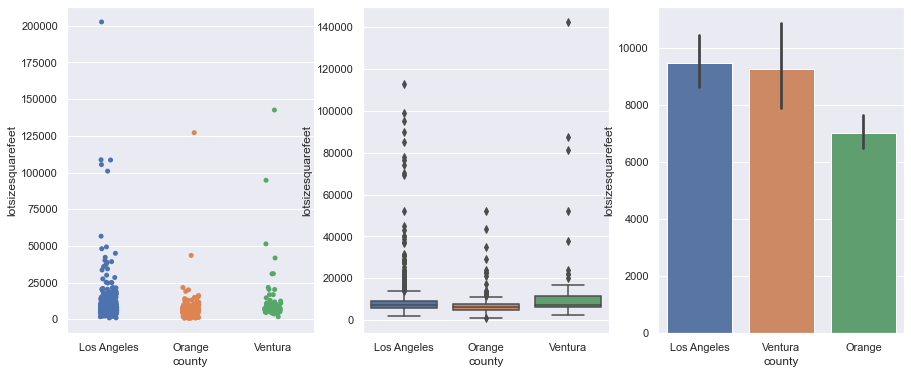

In [30]:
explore.plot_categorical_and_continuous_vars(train, columns_cat=['county'], columns_cont= ['lotsizesquarefeet'])

This is confirmed by the descriptive stats:

In [31]:
train.groupby('county')['lotsizesquarefeet'].describe()

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
Los Angeles,18575.0,9557.403445,11890.392816,931.0,5724.00,6899.0,8905.00,216820.0
Orange,7702.0,7242.288237,6268.783354,540.0,4845.75,6363.0,7937.25,178596.0
Ventura,2448.0,10873.639297,13093.535317,236.0,6050.00,7350.0,10149.25,187744.0


Orange county has the lowest mean, median and $0.75$ percentile of all three counties.  In addition, consider the `calculatedfinishedsquarefeet` by county:

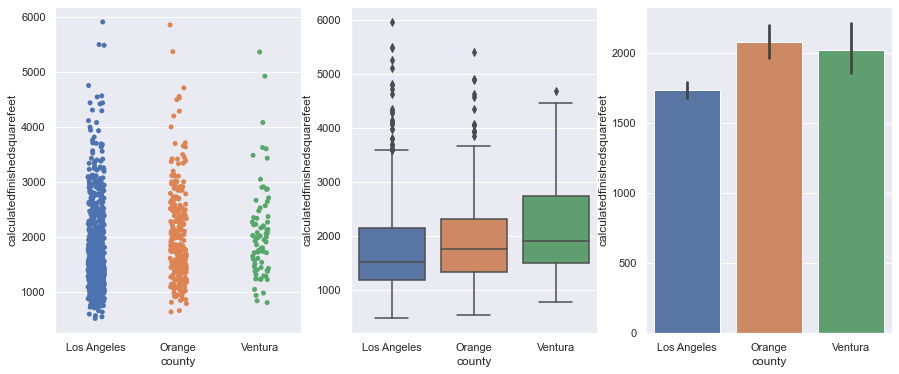

In [32]:
explore.plot_categorical_and_continuous_vars(train, columns_cat=['county'], columns_cont= ['calculatedfinishedsquarefeet'])

Consider also the numeric data:

In [33]:
train.groupby('county')['calculatedfinishedsquarefeet'].describe()

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
Los Angeles,18575.0,1768.526030,817.173267,326.0,1204.00,1554.0,2119.50,5986.0
Orange,7702.0,2088.226435,907.350396,384.0,1416.25,1868.0,2546.00,5995.0
Ventura,2448.0,2049.723039,865.274099,496.0,1428.75,1842.5,2495.25,6000.0


Both indicate that the `calculatedfinishedsquarefeet` in terms of both the mean, median and $0.75$ percentile (although the max is essentially the same across the counties.  Part of this is because of the data cleaning process which removed all extreme outliers.

Overall, it appears that Orange county has larger houses, which indicates a higher `taxvaluedollarcnt`.  However, `lotsizesquarefeet` is less predictive (in general), and by county as Orange county has a smaller lot size.

Consider the following hypothesis:

$H_0$ : The mean `taxvaluedollarcnt` in *county* is the same as the mean for homes not in *county*

$H_a$ : The mean `taxvaluedollarcnt` in *county* is different than the mean for homes not in *county*

Run a statistical test:

In [34]:
explore.t_test_by_cat(train, columns_cat = ['county'], columns_cont=['taxvaluedollarcnt'])

,category_name,column_name,p,reject_null
0,Los Angeles,taxvaluedollarcnt,1.515395e-116,True
1,Orange,taxvaluedollarcnt,6.162605e-80,True
2,Ventura,taxvaluedollarcnt,3.002683e-01,False


$H_0$ is likely false for Los Angeles and Orange counties.  This means that the mean `taxvaluedollarcnt` is different for Los Angeles and Orange counties.  $H_0$ is likely false for Ventura county, meaning that Ventura county mean `taxvaluedollarcnt` is likely the same as the general population.  Consider the above bar plot (<a href='#barplot'>here</a>).  Ventura county has a greater $0.95$ confidence interval; and it also has a small number of rows; this most likely factors into the statistical test.  To also confirm the numeric intuition from above, consider the following hypothesis:

$H_0$ : Orange county mean house price is less than or equal to the non-Orange county mean house price

$H_1$ : Orange county mean house price is greater than the non-Orange county mean house price

Run a statistical test:

In [35]:
alpha = 0.05
orange_sample = train[train['county'] == 'Los Angeles'].taxvaluedollarcnt
total_mean = train.taxvaluedollarcnt.mean()

t, p = stats.ttest_1samp(orange_sample, total_mean)

output = [{
    't-stat':t,
    'p-value':p,
    'reject_null':p/2 < alpha
}]
pd.DataFrame(output)

,t-stat,p-value,reject_null
0,-8.166901,3.364878e-16,True


$H_0$ is likely false. Orange county is likely more expensive than the other two counties.

<a href='#contents'>Back to contents</a>

### What is the relationship between `latitude` \ `logitude` \ `county` and `taxvaluedollarcnt`? <a name='hypothesis4'></a>

#### Key Takeaways
- Orange county has the highest proportion of luxury homes (defined as the top $0.25$ of home prices)
- County does not completely explain the geographic spread of home prices.  It looks like downtown Los Angeles is also a place with higher home prices.

It seems that Orange county has a higher mean house price.  Geographically, Orange county is close to the coast whereas the other counties extend farther inland.  Consider a graph of the `latitude` and `longitude` of points hued by county:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

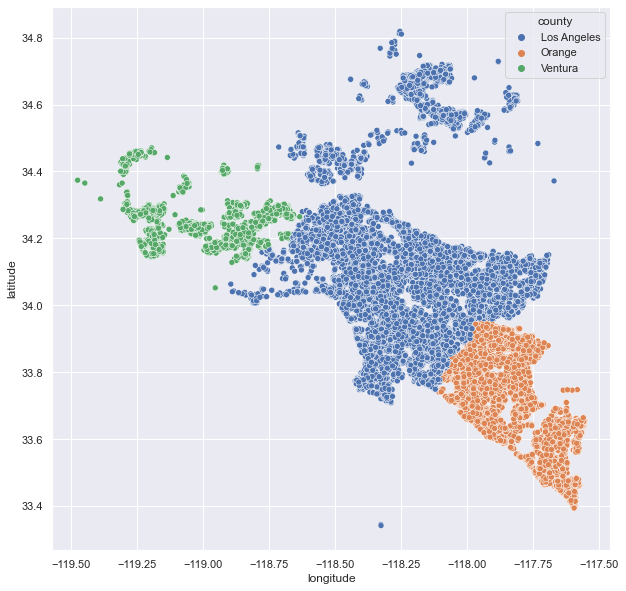

In [36]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=train, x='longitude', y='latitude', hue='county')

The counties are fairly clear from this alone. Compare with an image from wikipedia of the counties in the area:

<img src='https://upload.wikimedia.org/wikipedia/commons/7/76/Southern_California.png'></img>

However, coastal houses are often more expensive.  Consider houses in the top $0.25$ of the data--these are houses above $608k then make a column called `luxury_house` as a boolean.

In [37]:
train[['taxvaluedollarcnt']].describe().T

,count,mean,std,min,25%,50%,75%,max
taxvaluedollarcnt,28725.0,496926.378729,548528.058006,1000.0,191761.0,370829.0,608791.0,15618488.0


In [38]:
seventy_percentile = train['taxvaluedollarcnt'].quantile(0.75)

train['luxury_house'] = train['taxvaluedollarcnt'] >= seventy_percentile

train[['luxury_house']].mean()

luxury_house    0.250026
dtype: float64

Note that as expected, this represents the top $0.25$ of the data.  Now plot the column as a hue:

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

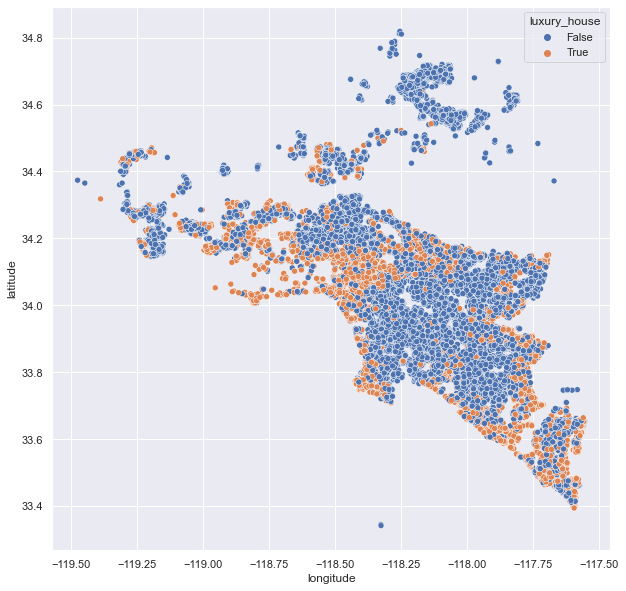

In [39]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=train, x='longitude', y='latitude', hue='luxury_house')

It appears that a lot of the `luxury_house` column are near the coast.  However, some are not; for example, downtown LA looks like there are more luxury houses. Also consider the percentage of houses in the column that are considered `luxury_house`.

In [40]:
train.groupby('county')['luxury_house'].sum()/train.groupby('county')['luxury_house'].count()

county
Los Angeles    0.209260
Orange         0.345884
Ventura        0.257761
Name: luxury_house, dtype: float64

As is expected Orange county has a high percentage of luxury houses.  Consider the following hypothesis:

$H_0$ : `county` is independent of `luxury_house`

$H_a$ : `county` is not independent of `luxury_house`

In [41]:
alpha = 0.05
observed = pd.crosstab(train['county'], train['luxury_house'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

output = [{
    'χ^2': chi2,
    'p':p,
    'reject_null': p < alpha
}]
pd.DataFrame(output)

,χ^2,p,reject_null
0,542.83206,1.335107e-118,True


$H_0$ is likely false. The presence of high value homes is related to county.

<a href='#contents'>Back to contents</a>

### Explore discussion <a name='explorediscussion'></a>

Overall the best predictor of house prices is `calculatedfinishedsquarefeet`, which is closely followed by number of bathrooms.  There could be multiple causal factors of this. Obviously, a larger house is made of more materials, which in turn means more cost.  In addition, bathrooms are often rooms where people spend a lot of money in terms of materials (for example, tiled vs marble floors, and the number of expensive fixtures such as toilets and baths). However, these do not completely explain the difference in prices--location is important.  Certain counties are predictive of hosue prices; this could be due to services at the county level.  However, another factor to consider are subcounty geographic categories, for example coastal vs inland and downtown vs not-downtown.

<a href='#contents'>Back to contents</a>

## Models <a name='models'></a>

This section will use the following functions from the custome modules:
- `wrangle.add_custom_columns()` adds the columns referenced in <a href='#explore'>explore</a>
- `wrangle.make_X_and_y()` which splits the data into the dependent and target variable sets.

This section will develop four models that will predict `taxvaluedollarcnt` from the available data.

First, the data is scaled and split into X and y sets:

In [42]:
#make custom columns
validate = wrangle.add_custom_columns(validate)
#scale the columns
train_scaled = wrangle.zillow_scale(train)
validate_scaled = wrangle.zillow_scale(validate)
#encode the categorical columns
train_scaled = wrangle.encode_columns(train_scaled)
validate_scaled = wrangle.encode_columns(validate_scaled)

In [43]:
# now split into X and y sets
X_train, y_train = wrangle.make_X_and_y(train_scaled)
X_validate, y_validate = wrangle.make_X_and_y(validate_scaled)

#y needs to be a dataframe
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

Now the models can be fit and used to make predictions

<a href='#contents'>Back to contents</a>

### Baseline models <a name='baseline'></a>

The baseline models are based on the mean and median.  Then the baseline models are used to calculate the RMSE.

In [44]:
#mean baseline model
y_train['baseline_mean_pred'] = y_train['taxvaluedollarcnt'].mean()
y_validate['baseline_mean_pred'] = y_train['taxvaluedollarcnt'].mean()

#median baseline model
y_train['baseline_median_pred'] = y_train['taxvaluedollarcnt'].median()
y_validate['baseline_median_pred'] = y_train['taxvaluedollarcnt'].median()

In [45]:
#determine the RMSE for the baseline models
#determine RSMSE
results = []

#calculate and store the results of the RMSE calculation
baseline_mean = {
    'model':'baseline_mean',
    'RMSE_train': mean_squared_error(y_train['taxvaluedollarcnt'], y_train['baseline_mean_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate['baseline_mean_pred'])**(0.5),
    'explained_variance_train' : explained_variance_score(y_train['taxvaluedollarcnt'], y_train['baseline_mean_pred']),
    'explained_variance_validate' : explained_variance_score(y_validate['taxvaluedollarcnt'], y_validate['baseline_mean_pred'])

}
baseline_median = {
    'model':'baseline_median',
    'RMSE_train': mean_squared_error(y_train['taxvaluedollarcnt'], y_train['baseline_median_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate['baseline_median_pred'])**(0.5),
    'explained_variance_train' : explained_variance_score(y_train['taxvaluedollarcnt'], y_train['baseline_median_pred']),
    'explained_variance_validate' : explained_variance_score(y_validate['taxvaluedollarcnt'], y_validate['baseline_median_pred'])

}
results.append(baseline_mean)
results.append(baseline_median)

Display the resulting dataframe with the RMSE values.

In [46]:
pd.DataFrame(results)

,model,RMSE_train,RMSE_validate,explained_variance_train,explained_variance_validate
0,baseline_mean,548518.510002,558482.348514,0.0,2.220446e-16
1,baseline_median,562825.998633,572659.048126,0.0,2.220446e-16


<a href='#contents'>Back to contents</a>

### Linear Regression Model <a name='linearregression'></a>

Fit the model and predict train and validate models to evaluate the data.

In [47]:
lm = LinearRegression(normalize = True)

lm.fit(X_train, y_train['taxvaluedollarcnt'])

y_train['lm_train_pred'] = lm.predict(X_train)

y_validate['lm_validate_pred'] = lm.predict(X_validate)

Calculate RMSE and residuals

In [48]:
#calculate and store the RMSE
lm_rmse = {
    'model':'linear regression',
    'RMSE_train': mean_squared_error(y_train['taxvaluedollarcnt'], y_train['lm_train_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate['lm_validate_pred'])**(0.5),
    'explained_variance_train' : explained_variance_score(y_train['taxvaluedollarcnt'], y_train['lm_train_pred']),
    'explained_variance_validate' : explained_variance_score(y_validate['taxvaluedollarcnt'], y_validate['lm_validate_pred'])
}
results.append(lm_rmse)
#calculate the residuals
y_train['lm_residuals'] = y_train['lm_train_pred'] - y_train['taxvaluedollarcnt']
y_validate['lm_residuals'] = y_validate['lm_validate_pred'] - y_validate['taxvaluedollarcnt']

pd.DataFrame(results)

,model,RMSE_train,RMSE_validate,explained_variance_train,explained_variance_validate
0,baseline_mean,548518.510002,5.584823e+05,0.000000,2.220446e-16
1,baseline_median,562825.998633,5.726590e+05,0.000000,2.220446e-16
2,linear regression,431121.232453,3.750954e+15,0.382245,-8.072351e+18


Plot the residuals of the validate

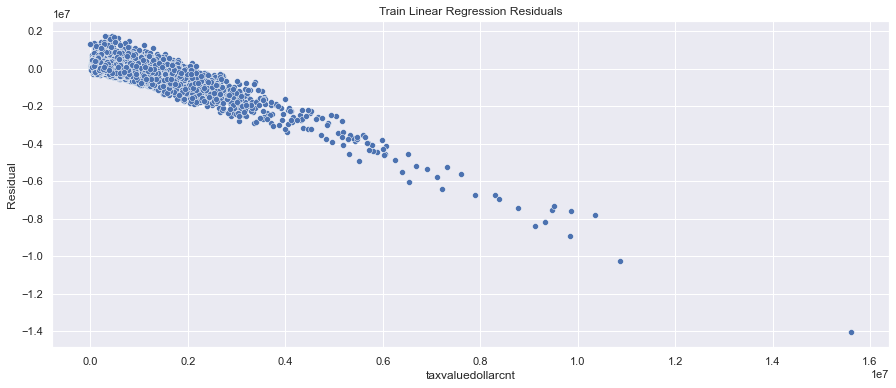

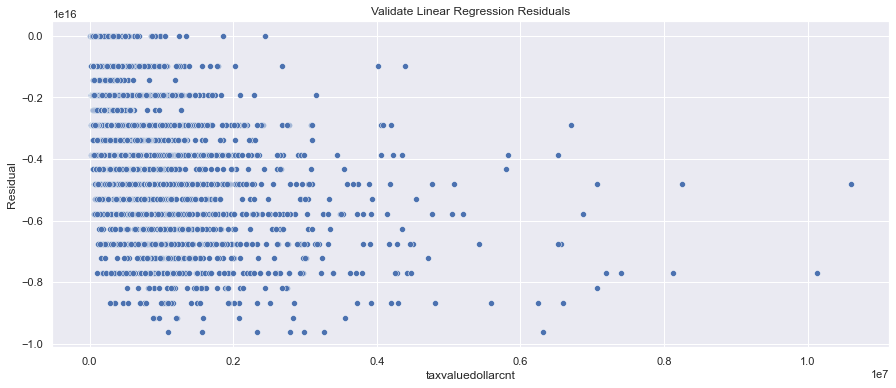

In [49]:
sns.scatterplot(data = y_train, x = 'taxvaluedollarcnt', y = 'lm_residuals')
plt.title('Train Linear Regression Residuals')
plt.ylabel('Residual')
plt.show()
sns.scatterplot(data = y_validate, x = 'taxvaluedollarcnt', y = 'lm_residuals')
plt.title('Validate Linear Regression Residuals')
plt.ylabel('Residual')
plt.show()

While the model is good for train data, it is overfit because the RMSE and residuals are significantly greater than the baseline models

### Lasso Lars Model <a name='lassolars'></a>

Fit the model and predict train and validate models to evaluate the data.

In [50]:
lars = LassoLars(alpha=1.0)

lars.fit(X_train, y_train['taxvaluedollarcnt'])

y_train['lars_train_pred'] = lars.predict(X_train)

y_validate['lars_validate_pred'] = lars.predict(X_validate)

Calculate RMSE and residuals

In [51]:
lars_rmse = {
    'model':'LassoLars regression',
    'RMSE_train': mean_squared_error(y_train['taxvaluedollarcnt'], y_train['lars_train_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate['lars_validate_pred'])**(0.5),
    'explained_variance_train' : explained_variance_score(y_train['taxvaluedollarcnt'], y_train['lars_train_pred']),
    'explained_variance_validate' : explained_variance_score(y_validate['taxvaluedollarcnt'], y_validate['lars_validate_pred'])

}
results.append(lars_rmse)
#calculate the residuals
y_train['lars_residuals'] = y_train['lars_train_pred'] - y_train['taxvaluedollarcnt']
y_validate['lars_residuals'] = y_validate['lars_validate_pred'] - y_validate['taxvaluedollarcnt']

pd.DataFrame(results)

,model,RMSE_train,RMSE_validate,explained_variance_train,explained_variance_validate
0,baseline_mean,548518.510002,5.584823e+05,0.000000,2.220446e-16
1,baseline_median,562825.998633,5.726590e+05,0.000000,2.220446e-16
2,linear regression,431121.232453,3.750954e+15,0.382245,-8.072351e+18
3,LassoLars regression,431123.523772,4.399441e+05,0.382238,3.826416e-01


Plot the residuals of the validate

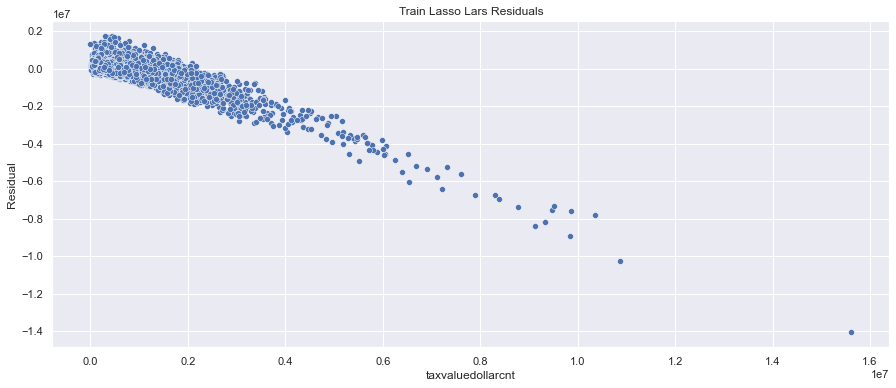

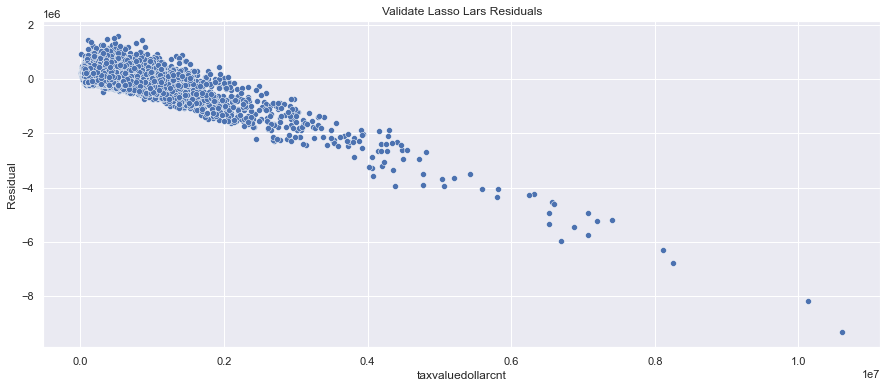

In [52]:
sns.scatterplot(data = y_train, x = 'taxvaluedollarcnt', y = 'lars_residuals')
plt.title('Train Lasso Lars Residuals')
plt.ylabel('Residual')
plt.show()
sns.scatterplot(data = y_validate, x = 'taxvaluedollarcnt', y = 'lars_residuals')
plt.title('Validate Lasso Lars Residuals')
plt.ylabel('Residual')
plt.show()

This model beats both baseline models.  Although it is not very good at predicting the outliers.

### Polynomial Regression Model <a name = 'polynomial'></a>

Fit the model and predict train and validate models to evaluate the data.

In [53]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train['taxvaluedollarcnt'])

# predict train
y_train['poly_train_pred'] = lm2.predict(X_train_degree2)

# predict validate
y_validate['poly_validate_pred'] = lm2.predict(X_validate_degree2)

Calculate RMSE and residuals

In [54]:
poly_rmse = {
    'model':'Polynomial regression',
    'RMSE_train': mean_squared_error(y_train['taxvaluedollarcnt'], y_train['poly_train_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate['poly_validate_pred'])**(0.5),
    'explained_variance_train' : explained_variance_score(y_train['taxvaluedollarcnt'], y_train['lars_train_pred']),
    'explained_variance_validate' : explained_variance_score(y_validate['taxvaluedollarcnt'], y_validate['lars_validate_pred'])

}
results.append(poly_rmse)
#calculate the residuals
y_train['poly_residuals'] = y_train['poly_train_pred'] - y_train['taxvaluedollarcnt']
y_validate['poly_residuals'] = y_validate['poly_validate_pred'] - y_validate['taxvaluedollarcnt']

pd.DataFrame(results)

,model,RMSE_train,RMSE_validate,explained_variance_train,explained_variance_validate
0,baseline_mean,548518.510002,5.584823e+05,0.000000,2.220446e-16
1,baseline_median,562825.998633,5.726590e+05,0.000000,2.220446e-16
2,linear regression,431121.232453,3.750954e+15,0.382245,-8.072351e+18
3,LassoLars regression,431123.523772,4.399441e+05,0.382238,3.826416e-01
4,Polynomial regression,410610.279117,8.187975e+15,0.382238,3.826416e-01


Plot the residuals of the validate

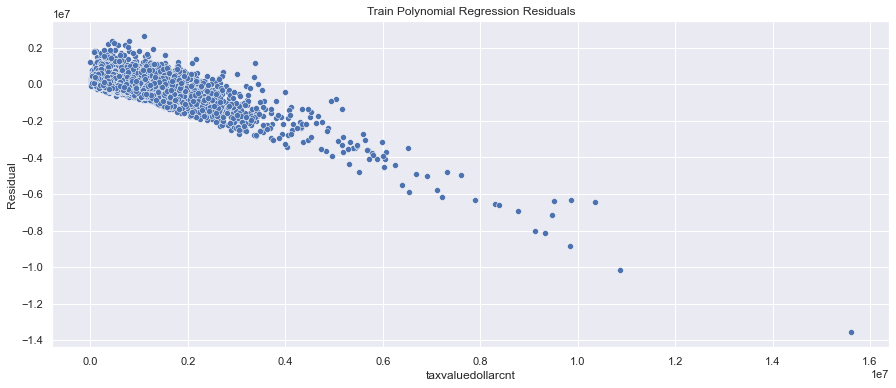

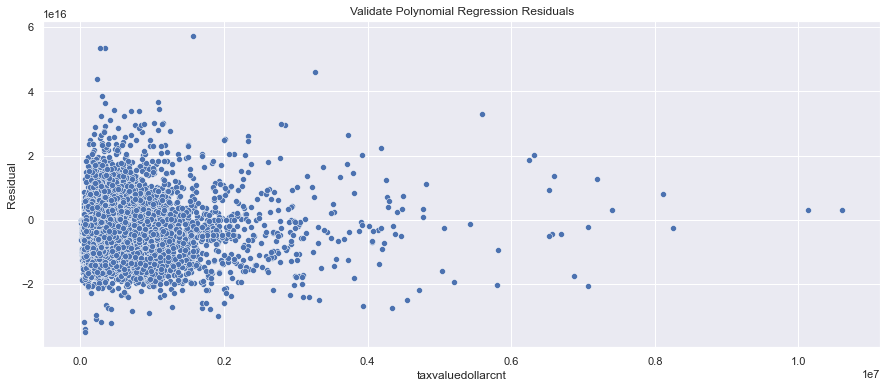

In [55]:
sns.scatterplot(data = y_train, x = 'taxvaluedollarcnt', y = 'poly_residuals')
plt.title('Train Polynomial Regression Residuals')
plt.ylabel('Residual')
plt.show()
sns.scatterplot(data = y_validate, x = 'taxvaluedollarcnt', y = 'poly_residuals')
plt.title('Validate Polynomial Regression Residuals')
plt.ylabel('Residual')
plt.show()

This model is significantly overfit.  It makes very bad predictions on the validate set.

### Tweedie Regressor <a name='tweedie'></a>

Fit the model and predict train and validate models to evaluate the data.

In [56]:
glm = TweedieRegressor()

glm.fit(X_train, y_train['taxvaluedollarcnt'])

y_train['glm_train_pred'] = glm.predict(X_train)

y_validate['glm_validate_pred'] = glm.predict(X_validate)

Calculate RMSE and residuals

In [57]:
glm_rmse = {
    'model':'TweedieRegressor regression',
    'RMSE_train': mean_squared_error(y_train['taxvaluedollarcnt'], y_train['glm_train_pred'])**(0.5),
    'RMSE_validate': mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate['glm_validate_pred'])**(0.5),
    'explained_variance_train' : explained_variance_score(y_train['taxvaluedollarcnt'], y_train['glm_train_pred']),
    'explained_variance_validate' : explained_variance_score(y_validate['taxvaluedollarcnt'], y_validate['glm_validate_pred'])

}
results.append(glm_rmse)
#calculate the residuals
y_train['glm_residuals'] = y_train['glm_train_pred'] - y_train['taxvaluedollarcnt']
y_validate['glm_residuals'] = y_validate['glm_validate_pred'] - y_validate['taxvaluedollarcnt']
pd.DataFrame(results)

,model,RMSE_train,RMSE_validate,explained_variance_train,explained_variance_validate
0,baseline_mean,548518.510002,5.584823e+05,0.000000,2.220446e-16
1,baseline_median,562825.998633,5.726590e+05,0.000000,2.220446e-16
2,linear regression,431121.232453,3.750954e+15,0.382245,-8.072351e+18
3,LassoLars regression,431123.523772,4.399441e+05,0.382238,3.826416e-01
4,Polynomial regression,410610.279117,8.187975e+15,0.382238,3.826416e-01
5,TweedieRegressor regression,536786.906678,5.468896e+05,0.042318,4.108347e-02


Plot the residuals of the validate

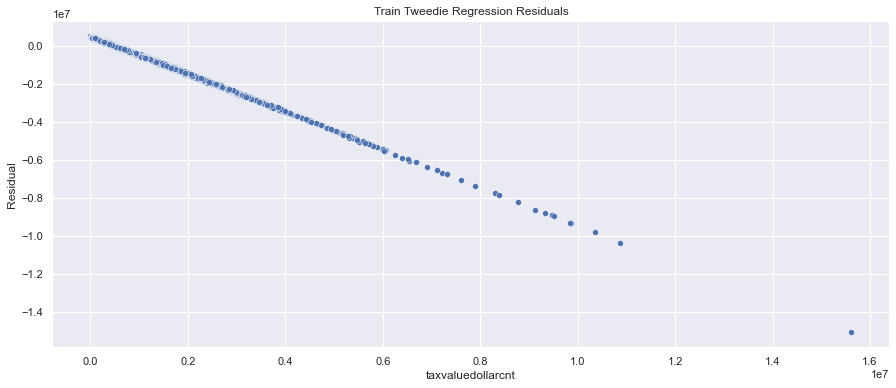

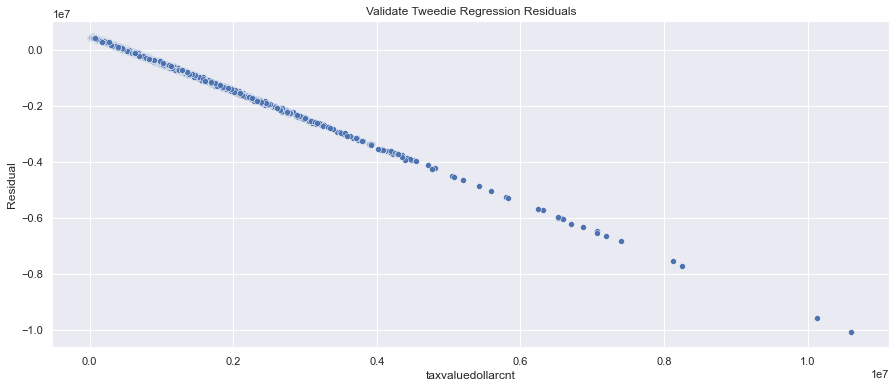

In [58]:
sns.scatterplot(data = y_train, x = 'taxvaluedollarcnt', y = 'glm_residuals')
plt.title('Train Tweedie Regression Residuals')
plt.ylabel('Residual')
plt.show()
sns.scatterplot(data = y_validate, x = 'taxvaluedollarcnt', y = 'glm_residuals')
plt.title('Validate Tweedie Regression Residuals')
plt.ylabel('Residual')
plt.show()

This is better than baseline, but still underestimating more expensive houses.

### Evaluating The Models Discussion <a name='evaluatingmodels'></a>

Consider the RMSE values for the train and validate sample sets.  Sort them by `RMSE_validate`.

In [59]:
df_results = pd.DataFrame(results)
df_results.iloc[:,0:3].sort_values('RMSE_validate')

,model,RMSE_train,RMSE_validate
3,LassoLars regression,431123.523772,4.399441e+05
5,TweedieRegressor regression,536786.906678,5.468896e+05
0,baseline_mean,548518.510002,5.584823e+05
1,baseline_median,562825.998633,5.726590e+05
2,linear regression,431121.232453,3.750954e+15
4,Polynomial regression,410610.279117,8.187975e+15


The best model is the LassoLars regression model.  It beats both baselines, and is consistent for both train and validate.  However, note that is tends to underestimate the higher value properties, while remaining reasonably good at predicting properties valued under $200k.

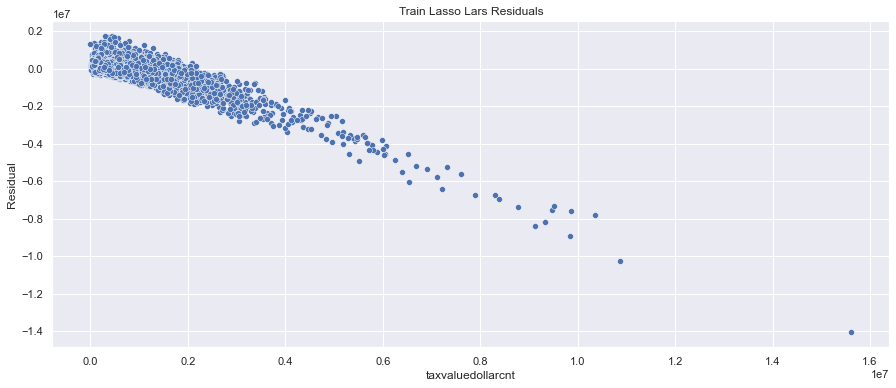

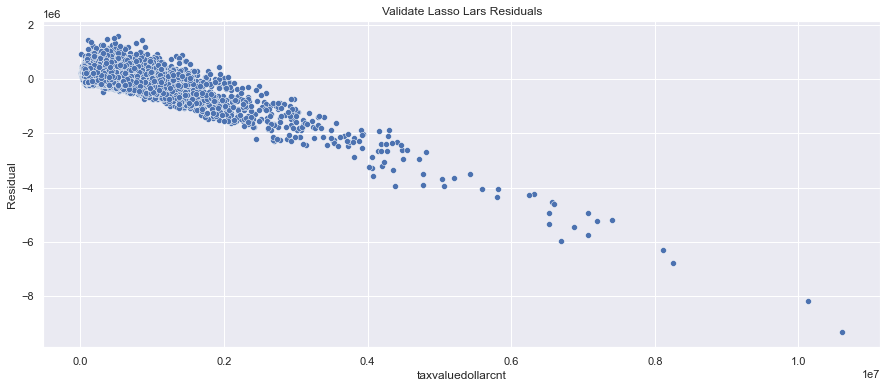

In [60]:
sns.scatterplot(data = y_train, x = 'taxvaluedollarcnt', y = 'lars_residuals')
plt.title('Train Lasso Lars Residuals')
plt.ylabel('Residual')
plt.show()
sns.scatterplot(data = y_validate, x = 'taxvaluedollarcnt', y = 'lars_residuals')
plt.title('Validate Lasso Lars Residuals')
plt.ylabel('Residual')
plt.show()

This can also be seen numerically below for the validate set:

In [61]:
y_validate[['lars_residuals']].describe()

,lars_residuals
count,1.231100e+04
mean,3.154857e+04
std,4.388292e+05
min,-9.345917e+06
25%,-1.047753e+05
50%,6.712426e+04
75%,2.418040e+05
max,1.588540e+06


<a href='#contents'>Back to contents</a>

### Using the model on Test data <a name='test'></a>

In order to test the model on unseen data, use the `test` data subset to evaluate the best model, the Lasso Lars.

Scale, encode and split the data into X and y sets.

In [62]:
#make custom columns
test = wrangle.add_custom_columns(test)
#scale the columns
test_scaled = wrangle.zillow_scale(test)
#encode the categorical columns
test_scaled = wrangle.encode_columns(test_scaled)

# now split into X and y sets
X_test, y_test = wrangle.make_X_and_y(test_scaled)

#y needs to be a dataframe
y_test = pd.DataFrame(y_test)

Predict based on the test data subset.  Then calculate the RMSE and explained variance.  Finally display the evaluation metrics.

In [63]:
y_test['test_pred'] = lars.predict(X_test)

test_results = []

test_rmse = {
    'model':'LassoLars test',
    'RMSE': mean_squared_error(y_test['taxvaluedollarcnt'], y_test['test_pred'])**(0.5),
    'explained_variance' : explained_variance_score(y_test['taxvaluedollarcnt'], y_test['test_pred'])

}
train_rmse = {
    'model':'LassoLars train',
    'RMSE': mean_squared_error(y_train['taxvaluedollarcnt'], y_train['lars_train_pred'])**(0.5),
    'explained_variance' : explained_variance_score(y_train['taxvaluedollarcnt'], y_train['lars_train_pred']),
}
validate_rmse = {
    'model':'LassoLars validate',
    'RMSE': mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate['lars_validate_pred'])**(0.5),
    'explained_variance' : explained_variance_score(y_validate['taxvaluedollarcnt'], y_validate['lars_validate_pred'])
}
test_results.append(train_rmse)
test_results.append(validate_rmse)
test_results.append(test_rmse)
#calculate the residuals
y_test['lars_residuals'] = y_test['test_pred'] - y_test['taxvaluedollarcnt']

test_results_df = pd.DataFrame(test_results)
test_results_df

,model,RMSE,explained_variance
0,LassoLars train,431123.523772,0.382238
1,LassoLars validate,439944.062146,0.382642
2,LassoLars test,445082.282647,0.381592


Plot the residuals:

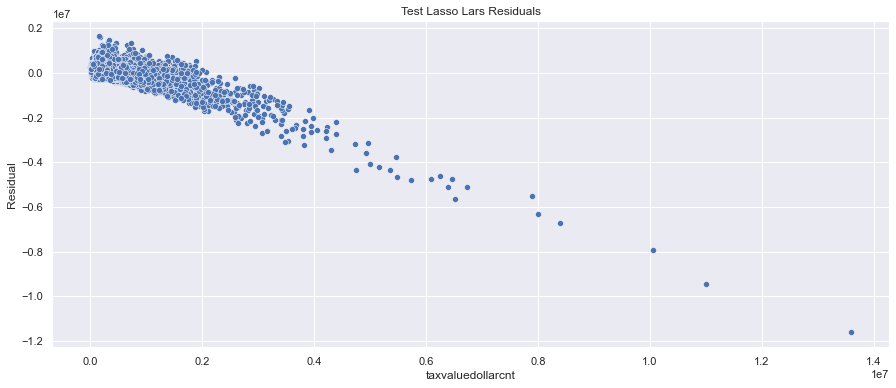

In [64]:
sns.scatterplot(data = y_test, x = 'taxvaluedollarcnt', y = 'lars_residuals')
plt.title('Test Lasso Lars Residuals')
plt.ylabel('Residual')
plt.show()

#### Discussion of tested model

The RMSE beats the baseline models, but has slightly higher error than from the train and validate sets. This can be seen in the following graph:

Text(0.5, 1.0, 'Change in RMSE across data subsets')

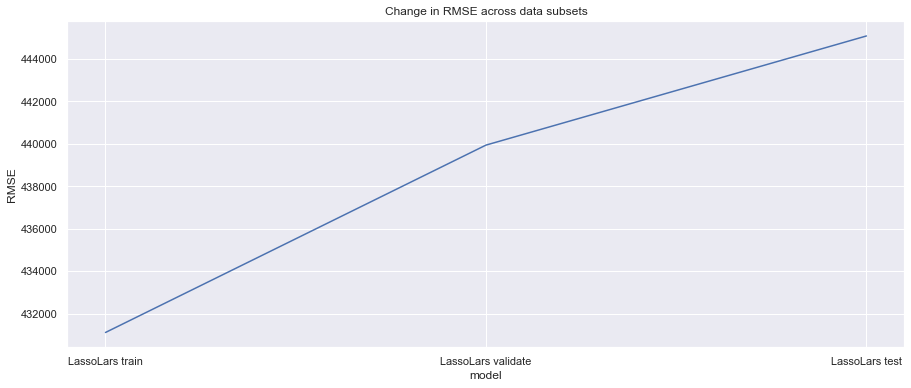

In [65]:
sns.lineplot(data = test_results_df, x= 'model', y='RMSE')
plt.title('Change in RMSE across data subsets')

The same data, but numerically:

In [66]:
test_results_df.set_index('model')

,RMSE,explained_variance
model,,
LassoLars train,431123.523772,0.382238
LassoLars validate,439944.062146,0.382642
LassoLars test,445082.282647,0.381592


<a href='#contents'>Back to contents</a>

## Conclusion <a name='conclusion'></a>

Major drivers of the house price are the following:
- The size of the house in square feet.  Larger houses are most expensive.
- The number of bathrooms. Like bedrooms, houses generally have more than one bathroom. In addition bathrooms tend to have materials that are most costly than others rooms.
- Location. Some counties are more likely to have expensive homes than others, and different areas within counties (for example downtown or near the coast) tend to be more expensive

A LassoLars regression model predicts the house price with reasonable predictions, although it tends to underestimate the houses at the higher end of the market.

### Recommendations for the future

From the exploration <a href='#explore'>section</a> it is clear that one of drivers of the house price is the house's geography. There are the building blocks of starting this analysis within the data.  For example, the data set contains census data blocks; if these were merged with data from the census bureau, that would give information on local economic, transportation, demographic, employment, etc information that could help determine house prices. In addition, using the latitude and longitude to determine the average price within a radius of the house could be useful, as I suspect that expensive houses are near other expensive houses; even better, if the values of an additional bedroom or bathroom within a neighborhood are calculated, this could be built into the model.

Another way to improve the predictions would be to clean the data differently in terms of outliers.  As it currently is done, there remain a lot of outliers within the data, and the model is not very good at predicting houses in the extreme upper end of the spectrum of house prices.  If more data was excluded initially, the model would be better at predictions for more typical houses, and another model could be used for luxury houses.  Intuitively the logic is this: there is a upper limit to the size of the house, but the materials of the house really have no upper limit (for example, everything could be made of gold in an extreme/gaudy case, or the entire house could be tiled in marble).

<a href='#contents'>Back to contents</a>